# Graph-level Classification

In SARS-CoV-2 studies, the spike protein (antigen), particularly the receptor-binding domain (RBD), is commonly mutated to map epitopes. In this project, we wish to predict the class of antibody epitopes for which an antibody sequence is likely to bind to. This will make us able to create epitope specific MSAs when feeding the classifier with multiple sequences. The MSA can enhance the performance when predicting antigen-antibody complexes using AlphaFold3.

The aim of this notebook is to classify the antibodies when representing the proteins as graphs. These representations are constructed from ESM-2 embeddings and contact scores. A Graph Neural Network (GNN) is trained for graph level predictions..

### Preparation

We install PyTorch Geometric (PyG) used for to write and train GNNs.



In [3]:
%%capture

!pip install torch torch-geometric matplotlib

The required libraries are loaded.

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import esm
import pickle
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn.conv import GCNConv
from torch.utils.data import random_split
import torch.nn.functional as F
from torch_geometric.nn.pool import global_mean_pool

### Data Import

We will import the data.

In [16]:
work_dir = os.getcwd()
data_dir = os.path.join(work_dir, '../data')
data = pd.read_excel(os.path.join(data_dir, 'external/antibody_info.xlsx'), header=1)
display(data)

,Antibody Name,Epitope Group,source,D614G,BA.1,BA.2,BA.2.75,BA.5,BQ.1.1,XBB,Heavy chain V gene,Heavy chain J gene,Light chain V gene,Light chain J gene,Heavy chain AA,Light chain AA
0,BD-196,C,WT convalescents,1.93,>10,>10,>10,>10,>10,>10,IGHV1-3,IGHJ6,IGKV2-58,IGKJ1,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...
1,BD-218,A,WT convalescents,0.0104,0.00849,0.00937,0.0116,5.26,>10,>10,IGHV4-34,IGHJ1,IGKV3-11,IGKJ5,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...
2,BD-236,A,WT convalescents,0.0173,>10,>10,>10,>10,>10,>10,IGHV3-53,IGHJ6,IGKV1-9,IGKJ4,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...
3,BD-254,C,WT convalescents,0.25,>10,>10,>10,>10,>10,>10,IGHV3-23,IGHJ4,IGLV7-46,IGLJ2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...
4,BD-255,B,WT convalescents,0.113,>10,>10,>10,>10,>10,>10,IGHV3-30,IGHJ6,IGKV3-15,IGKJ2,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,BD55-6726,E2.2,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-58,IGHJ2,IGKV3-24,IGKJ1,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...
3047,BD55-6727,F2,SARS convalescents,0.293,4.37,>10,>10,>10,>10,>10,IGHV3-11,IGHJ1,IGKV1-39,IGKJ2,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...
3048,BD55-6728,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV3-64,IGHJ2,IGKV1-39,IGKJ1,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...
3049,BD55-6729,F1,SARS convalescents,>10,>10,>10,>10,>10,>10,>10,IGHV1-18,IGHJ6,IGLV3-25,IGLJ2,QVQLVQSGAEVKKPGTSMRVSCKASGYTFSTYGIIWVRQAPGQGLE...,SYELTQPPSVSVSPGQTARITCSGDAVATQFLYWYQQKSGQAPVMV...


We will be interested in the epitope group and both the heavy and light chain in the data above. Let us look at the distribution of the lengths of the heavy and light chain.

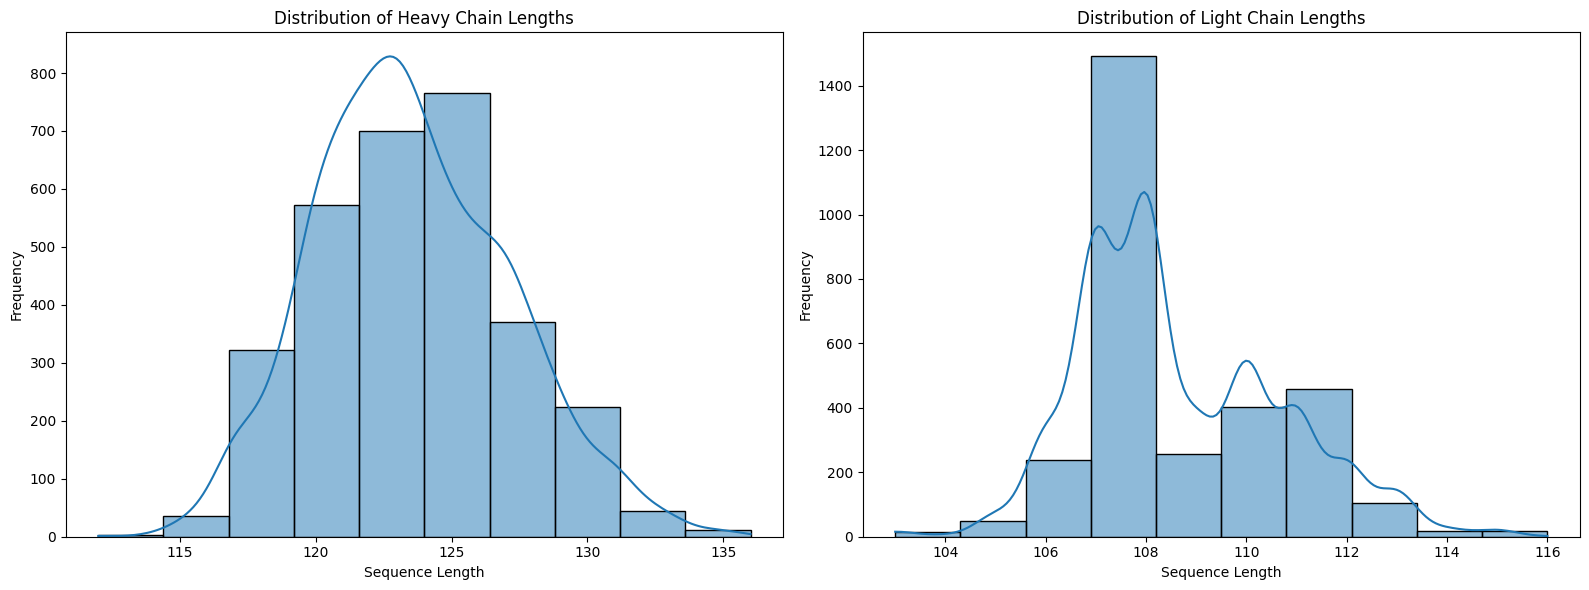

In [10]:
# Extract the sequencces
heavy_sequences = list(data['Heavy chain AA'])
light_sequences = list(data['Light chain AA'])

# Calculate lengths
heavy_sequence_lengths = [len(seq) for seq in heavy_sequences]
light_sequence_lengths = [len(seq) for seq in light_sequences]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  

# Heavy chain plot
sns.histplot(heavy_sequence_lengths, kde=True, bins=10, ax=axs[0])
axs[0].set_title('Distribution of Heavy Chain Lengths')
axs[0].set_xlabel('Sequence Length')
axs[0].set_ylabel('Frequency')

# Light chain plot
sns.histplot(light_sequence_lengths, kde=True, bins=10, ax=axs[1])
axs[1].set_title('Distribution of Light Chain Lengths')
axs[1].set_xlabel('Sequence Length')
axs[1].set_ylabel('Frequency')

# Adjust layout and show
plt.tight_layout()
plt.show()

The class label (Epitope Group) is a character. We convert this into a integer. The new column is named "Epitope Class". This will be our target for the classification model. 

In [17]:
# Generate mapping dictionary.
epitope_mapping = {group: code for code, group in enumerate(pd.Categorical(data['Epitope Group']).categories)}

# Map the Epitope Group column using the dictionary
data['Epitope Class'] = data['Epitope Group'].map(epitope_mapping)

display(data[['Epitope Group', 'Epitope Class', 'Heavy chain AA', 'Light chain AA']])

,Epitope Group,Epitope Class,Heavy chain AA,Light chain AA
0,C,2,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYAMHWVRQAPGQRLE...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLNWFQQRPG...
1,A,0,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSDYFWYWIRQPPGKGLE...,EIVLTQSPATLSLSPGERATLSCRASQSVSSYLAWYQQKPGQAPRL...
2,A,0,EVQLVESGGGLIQPGGSLRLSCAASGITVSSNYMSWVRQAPGKGLE...,IQLTQSPSSLSASVGDRVTITCRASQGISSYLAWYQQKPGKAPKLL...
3,C,2,EVQLLESGGGLVQPGGSLRLSCAASGFTLSSYAMSWVRQAPGRGLE...,QAVVTQEPSLTVSPGGTVTLTCGSSTGAVTSGHYPYWFQQKPGQAP...
4,B,1,QVQLVESGGGVVQPGRSLRLSCVASGFTFSNYDMHWVRQAPGKGLE...,EIVMTQSPAILSVSPGERATLSCRASQSVTRNLAWYQQKPGQAPRL...
...,...,...,...,...
3046,E2.2,7,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...,EIVLRQSPATVSLSPGERATLSCRASQSVHNYLAWFQQKPGQAPRL...
3047,F2,10,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...,DIQMTQSPSSLSASVGDRVTITCRASQSISNYLNWYQQKPGKAPKL...
3048,F1,9,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...,DIQMTQSPSSLSASLGDRVTITCRASQTISRYLNWYQQKPGKAPKV...
3049,F1,9,QVQLVQSGAEVKKPGTSMRVSCKASGYTFSTYGIIWVRQAPGQGLE...,SYELTQPPSVSVSPGQTARITCSGDAVATQFLYWYQQKSGQAPVMV...


The relation between epitope group and their class label is seen here:

In [18]:
print("Epitope to Group Mapping:", epitope_mapping)

Epitope to Group Mapping: {'A': 0, 'B': 1, 'C': 2, 'D1': 3, 'D2': 4, 'E1': 5, 'E2.1': 6, 'E2.2': 7, 'E3': 8, 'F1': 9, 'F2': 10, 'F3': 11}


### ESM-2 Representation

Results from feeding the smallest ESM-2 model (esm2_t6_8M_UR50D) with the heavy and light chain sequences have already been generated. We will load these results in the format of a pickle file which retain the dict data format after running ESM-2. 

In [35]:
with open('../data/processed/embed_EMS_8_seperate', 'rb') as f:
    data_esm2 = pickle.load(f)

The ESM-2 model will output the embeddings as well as contact scores, which describes the likelihood that two specific residues in the protein are in close physical proximity when the protein folds into its three-dimensional structure.

In [36]:
data_esm2.keys()

dict_keys(['representations', 'contacts'])

We need to modify ESM-2 data a bit to combine the information from both chains. Thus, we must concatenate the embeddings, such that we get one embedding vector per amino acid. However, all sequence representations will be of the same length, as the ESM-2 model apply padding as well as include a start and stop token. Thus, we need to adjust for that as the first step for both representations and contacts. The contact matrices will also be combined such that the contact map between the heavy and light chains will be filled with zero matrices. 

In [78]:
# Get number of proteins in the data
protein_num = int(data.shape[0])

# Extract representations
representations = data_esm2['representations'][6]
contacts = data_esm2['contacts']

# Define heavy and light chain representations
representations_heavy = representations[:protein_num, :, :]
representations_light = representations[protein_num:, :, :]
contacts_heavy = representations[:protein_num, :, :]
contacts_light = representations[protein_num:, :, :]

# Define empty lists
representations_list = []
contacts_list = []

for index in range(protein_num):
    
    # Remove the zero padding and start and stop tokens
    representation_heavy = representations_heavy[index, 1:heavy_sequence_lengths[index]+1, :]
    representation_light = representations_light[index, 1:light_sequence_lengths[index]+1, :]
    contact_heavy = contacts_heavy[index, 1:heavy_sequence_lengths[index]+1, 1:heavy_sequence_lengths[index]+1]
    contact_light = contacts_light[index, 1:light_sequence_lengths[index]+1, 1:light_sequence_lengths[index]+1]
    
    # Concatenate the representations for both chains
    representations_list.append(torch.cat((representation_heavy, representation_light), dim=0))
    
    # Make a combined contact matrix
    zero_padding_1 = torch.zeros(heavy_sequence_lengths[index], light_sequence_lengths[index])
    zero_padding_2 = torch.zeros(light_sequence_lengths[index], heavy_sequence_lengths[index])  
    contact_full = torch.cat([ torch.cat([contact_heavy , zero_padding_1], dim=1), torch.cat([zero_padding_2, contact_light], dim=1)], dim=0)
    
    contacts_list.append(contact_full)

### Create Graphs

We now have the embeddings for each amino acids, which we will use as nodes. Amino acids with contacts above a certain threshold will be considered as neighbors. We create the graphs using PyG. Each protein graph will be generated by providing the folowing features:

- x: Node feature matrix with shape [num_nodes, num_node_features]. This will be the number of amino acids x embedding dimension.

- edge_index: Graph connectivity with shape [2, num_edges]. This will be neighboring amino acids within the protein.

- edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]. This will be the score betweeen amino acids from the contact map.

data.y: This will be the target. In our case, we wish to predict the epitope class.

In [84]:
pygraphs = []
threshold = 0.7
epitope_classes = torch.tensor(data['Epitope Class'].values, dtype=torch.long)
epitope_classes = epitope_classes.unsqueeze(0)

for index in range(protein_num):

  contacts = contacts_list[index]

  edge_indices = (contacts > threshold).nonzero(as_tuple=False).T
  edge_scores = contacts[edge_indices[0], edge_indices[1]]

  # Create Data object
  graph = Data(x = representations_list[index],
               edge_index = edge_indices,
               edge_attr = edge_scores.unsqueeze(1),
               y = epitope_classes[:, index])

  pygraphs.append(graph)

In [85]:
pygraphs

[Data(x=[239, 320], edge_index=[2, 867], edge_attr=[867, 1], y=[1]),
 Data(x=[227, 320], edge_index=[2, 774], edge_attr=[774, 1], y=[1]),
 Data(x=[224, 320], edge_index=[2, 722], edge_attr=[722, 1], y=[1]),
 Data(x=[232, 320], edge_index=[2, 823], edge_attr=[823, 1], y=[1]),
 Data(x=[230, 320], edge_index=[2, 762], edge_attr=[762, 1], y=[1]),
 Data(x=[233, 320], edge_index=[2, 855], edge_attr=[855, 1], y=[1]),
 Data(x=[228, 320], edge_index=[2, 837], edge_attr=[837, 1], y=[1]),
 Data(x=[228, 320], edge_index=[2, 699], edge_attr=[699, 1], y=[1]),
 Data(x=[237, 320], edge_index=[2, 749], edge_attr=[749, 1], y=[1]),
 Data(x=[223, 320], edge_index=[2, 737], edge_attr=[737, 1], y=[1]),
 Data(x=[235, 320], edge_index=[2, 888], edge_attr=[888, 1], y=[1]),
 Data(x=[224, 320], edge_index=[2, 691], edge_attr=[691, 1], y=[1]),
 Data(x=[225, 320], edge_index=[2, 711], edge_attr=[711, 1], y=[1]),
 Data(x=[231, 320], edge_index=[2, 756], edge_attr=[756, 1], y=[1]),
 Data(x=[234, 320], edge_index=[2,

### Classification Model

In [101]:
# Split dataset into training and test sets
train_size = int(0.7 * len(pygraphs))
test_size = len(pygraphs) - train_size
train_dataset, test_dataset = random_split(pygraphs, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

/home/VM01jobao/miniconda3/envs/proteusAI/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [102]:
print(train_size)
print(test_size)

2135
916


In [103]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim) # maps the learned graph-level feature representations to the output space, enabling prediction tasks.

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch) # Essential for aggregating node-level features into a single graph-level feature vector.
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Initialize model, loss, and optimizer
num_class = torch.max(epitope_classes).item() + 1
num_features = representations_list[0].size()[1]

model = GNN(input_dim=num_features, hidden_dim=100, output_dim = num_class)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [104]:
for epoch in range(100):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 52.3917
Epoch 2, Loss: 49.6425
Epoch 3, Loss: 48.1723
Epoch 4, Loss: 47.2173
Epoch 5, Loss: 45.5262
Epoch 6, Loss: 43.9995
Epoch 7, Loss: 42.4791
Epoch 8, Loss: 40.7466
Epoch 9, Loss: 39.7473
Epoch 10, Loss: 39.0697
Epoch 11, Loss: 38.5762
Epoch 12, Loss: 37.8736
Epoch 13, Loss: 37.0235
Epoch 14, Loss: 36.2607
Epoch 15, Loss: 35.8011
Epoch 16, Loss: 35.7403
Epoch 17, Loss: 33.8536
Epoch 18, Loss: 33.5367
Epoch 19, Loss: 33.7446
Epoch 20, Loss: 32.6801
Epoch 21, Loss: 32.4251
Epoch 22, Loss: 32.5329
Epoch 23, Loss: 31.4863
Epoch 24, Loss: 31.7820
Epoch 25, Loss: 30.6527
Epoch 26, Loss: 29.9767
Epoch 27, Loss: 29.4827
Epoch 28, Loss: 30.6824
Epoch 29, Loss: 28.7069
Epoch 30, Loss: 27.8019
Epoch 31, Loss: 27.4154
Epoch 32, Loss: 27.0745
Epoch 33, Loss: 27.0928
Epoch 34, Loss: 27.2206
Epoch 35, Loss: 27.0491
Epoch 36, Loss: 25.8116
Epoch 37, Loss: 24.6937
Epoch 38, Loss: 24.9731
Epoch 39, Loss: 25.3497
Epoch 40, Loss: 24.9414
Epoch 41, Loss: 24.5799
Epoch 42, Loss: 23.6547
E

In [106]:
model.eval()
correct = 0
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)
    correct += (pred == data.y).sum().item()

accuracy = correct / len(test_dataset)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.51


Test git